## Se prueba la optimización random (y se analizan versiones cambiando los margenes)

Usamos la sala de prueba 1

In [1]:
import os
import time
os.chdir('..')

In [2]:
from room.geometry_generator import calculation_of_geometry
from mesh.mesh_3D_complex import create_complex_mesh
from FEM.FEM_source import FEM_Source_Solver_Average
from aux.merit_figure import merit_magnitude_deviation, merit_spatial_deviation
from plots.graph_room_outline import plot_room_outline

import numpy as np
import matplotlib.pyplot as plt

pygame 2.6.1 (SDL 2.28.4, Python 3.10.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [33]:
# Definimos el cuarto
Lx = 250       # Largo de la sala en X 
Ly = 300       # Largo de la sala en Y
Lz = 220       # Alto de la sala
Dx = 20        # Delta X (10, 20, 50)
Dy = 40        # Delta Y (20, 40, 80)
Dz = 10        # Delta Z (5, 10, 20)

# Posiciones fuente y receptor (en metros)
source_position = (1.9, 1.0, 1.3)
receptor_position = (1.25, 1.9, 1.2)

El resultado con 2 paredes es el base

In [34]:
# Parametros de control
N = 250        # Densidad de la grilla del generador de geometrías
M = 200        # Cantidad de salas a generar
n_walls = 2    # Número de cortes en las paredes
res_freq = 1

Busqueda de salas para el caso 1 (menor margen). Se bajo las salas porque le costaba encontrar 200 salas únicas.

In [24]:
rooms = calculation_of_geometry(Lx, Ly, Dx, Dy, N, 75, n_walls, verbose=True)
rooms

Cantidad de iteraciones:  1
Cantidad de salas encontradas:  0
Cantidad de iteraciones:  2
Cantidad de salas encontradas:  0
Cantidad de iteraciones:  3
Cantidad de salas encontradas:  0
Cantidad de iteraciones:  4
Cantidad de salas encontradas:  0
Cantidad de iteraciones:  5
Cantidad de salas encontradas:  0
Cantidad de iteraciones:  6
Cantidad de salas encontradas:  0
Cantidad de iteraciones:  7
Cantidad de salas encontradas:  0
Cantidad de iteraciones:  8
Cantidad de salas encontradas:  0
Cantidad de iteraciones:  9
Cantidad de salas encontradas:  0
Cantidad de iteraciones:  10
Cantidad de salas encontradas:  0
Cantidad de iteraciones:  11
Cantidad de salas encontradas:  0
Cantidad de iteraciones:  12
Cantidad de salas encontradas:  0
Cantidad de iteraciones:  13
Cantidad de salas encontradas:  0
Cantidad de iteraciones:  14
Cantidad de salas encontradas:  0
Cantidad de iteraciones:  15
Cantidad de salas encontradas:  0
Cantidad de iteraciones:  16
Cantidad de salas encontradas:  0
C

[array([[0.52083333, 0.        ],
        [0.06      , 0.18      ],
        [0.06      , 2.82      ],
        [0.9375    , 3.        ],
        [1.5625    , 3.        ],
        [2.44      , 2.82      ],
        [2.44      , 0.18      ],
        [1.97916667, 0.        ]]),
 array([[0.52083333, 0.        ],
        [0.06      , 0.12      ],
        [0.        , 3.        ],
        [0.9375    , 3.        ],
        [1.5625    , 3.        ],
        [2.5       , 3.        ],
        [2.44      , 0.12      ],
        [1.97916667, 0.        ]]),
 array([[0.52083333, 0.        ],
        [0.        , 0.06      ],
        [0.        , 2.88      ],
        [0.9375    , 3.        ],
        [1.5625    , 3.        ],
        [2.5       , 2.88      ],
        [2.5       , 0.06      ],
        [1.97916667, 0.        ]]),
 array([[0.52083333, 0.        ],
        [0.        , 0.06      ],
        [0.06      , 2.94      ],
        [0.9375    , 3.        ],
        [1.5625    , 3.        ],
        

In [35]:
# Almacenar toda la data
start_time = time.time()
rooms = calculation_of_geometry(Lx, Ly, Dx, Dy, N, M, n_walls)
mesh = "room_mesh_complex"  # Crear malla con el script correspondiente
mesh1 = "room_mesh_complex1"  # Crear malla con el script correspondiente
mesh2 = "room_mesh_complex2"  # Crear malla con el script correspondiente
mesh3 = "room_mesh_complex3"  # Crear malla con el script correspondiente
mag_responses = []
merit_sv_values = []
merit_md_values = []

# Itera y almacena los valores para encontrar el mejor cuarto
for i in range(M):
    print("Vamos por el room: ", i)

    # Crea la malla de la geometría selecionada
    Z = (Lz - np.random.uniform(0, Dz))/100
    create_complex_mesh(rooms[i], Z, source_position, 80, mesh1)
    create_complex_mesh(rooms[i], Z, source_position, 140, mesh2)
    create_complex_mesh(rooms[i], Z, source_position, 200, mesh3)

    # Evalua la rta en frecuencia para esa sala
    f1 = np.arange(20, 80, res_freq)
    res1 = FEM_Source_Solver_Average(f1, f'mallado/{mesh1}.msh', receptor_position)

    f2 = np.arange(80, 140, res_freq)
    res2 = FEM_Source_Solver_Average(f2, f'mallado/{mesh2}.msh', receptor_position)

    f3 = np.arange(140, 200, res_freq)
    res3 = FEM_Source_Solver_Average(f3, f'mallado/{mesh3}.msh', receptor_position)

    res_tot = np.hstack([res1, res2, res3])
    res_tot_prom = np.sum(res_tot, axis=0) / 7

    # Calcula figuras de mérito
    sv_merit = merit_spatial_deviation(res_tot)
    md_merit = merit_magnitude_deviation(res_tot)
    
    merit_sv_values.append(sv_merit)
    merit_md_values.append(md_merit)
    mag_responses.append(res_tot_prom)

f_tot =  np.hstack([f1, f2, f3])
merit_sv_values = np.array(merit_sv_values)
merit_md_values = np.array(merit_md_values)
merit_general = merit_md_values + merit_sv_values

idx_best_room = np.argmin(merit_general)
idx_worst_room = np.argmax(merit_general)

best_room_mag = mag_responses[idx_best_room]
worst_room_mag = mag_responses[idx_worst_room]
random_room_mag = mag_responses[np.random.randint(0, M - 1)]


Vamos por el room:  0
Info    : Reading 'mallado/room_mesh_complex1.msh'...
Info    : 57 entities
Info    : 596 nodes
Info    : 3195 elements
Info    : Done reading 'mallado/room_mesh_complex1.msh'
Info    : Reading 'mallado/room_mesh_complex2.msh'...
Info    : 57 entities
Info    : 1620 nodes
Info    : 9116 elements
Info    : Done reading 'mallado/room_mesh_complex2.msh'
Info    : Reading 'mallado/room_mesh_complex3.msh'...
Info    : 57 entities
Info    : 5550 nodes
Info    : 32969 elements
Info    : Done reading 'mallado/room_mesh_complex3.msh'
Vamos por el room:  1
Info    : Reading 'mallado/room_mesh_complex1.msh'...
Info    : 57 entities
Info    : 539 nodes
Info    : 2883 elements
Info    : Done reading 'mallado/room_mesh_complex1.msh'
Info    : Reading 'mallado/room_mesh_complex2.msh'...
Info    : 57 entities
Info    : 1746 nodes
Info    : 9854 elements
Info    : Done reading 'mallado/room_mesh_complex2.msh'
Info    : Reading 'mallado/room_mesh_complex3.msh'...
Info    : 57 entit

Resultado con margenes chicos

In [26]:
print(f"El valor de mértio mínimo es: {merit_general[idx_best_room]} | Con SV: {merit_sv_values[idx_best_room]} | Con MD: {merit_md_values[idx_best_room]}" )
print("............................")
print(f"El peor valor de mérito es: {merit_general[idx_worst_room]} | Con SV: {merit_sv_values[idx_worst_room]} | Con MD: {merit_md_values[idx_worst_room]}" )
print("............................")
print("El valor de mértio promedio es: ", np.mean(merit_general))
print("............................")
print("El tiempo de ejecución en minutos fue de: ", (time.time() - start_time)/60)

El valor de mértio mínimo es: 14.56742790547899 | Con SV: 3.35882964073223 | Con MD: 11.20859826474676
............................
El peor valor de mérito es: 19.399561233330214 | Con SV: 4.225508670348164 | Con MD: 15.17405256298205
............................
El valor de mértio promedio es:  15.871401910738337
............................
El tiempo de ejecución en minutos fue de:  74.39331123431523


In [27]:
from complex_outline_optim import calculate_initial

merit_0, mag0 = calculate_initial(Lx/100, Ly/100, Lz/100, source_position, receptor_position)
freq_base = np.arange(20, 200, 1)
merit_0

Info    : Reading 'mallado/room_base_optim1.msh'...
Info    : 33 entities
Info    : 705 nodes
Info    : 3928 elements
Info    : Done reading 'mallado/room_base_optim1.msh'
Info    : Reading 'mallado/room_base_optim2.msh'...
Info    : 33 entities
Info    : 1858 nodes
Info    : 10518 elements
Info    : Done reading 'mallado/room_base_optim2.msh'
Info    : Reading 'mallado/room_base_optim3.msh'...
Info    : 33 entities
Info    : 6201 nodes
Info    : 36807 elements
Info    : Done reading 'mallado/room_base_optim3.msh'


(15.935706884213301, 12.540030814890079, 3.3956760693232226)

In [31]:
best_mag_small_margin = np.copy(best_room_mag)

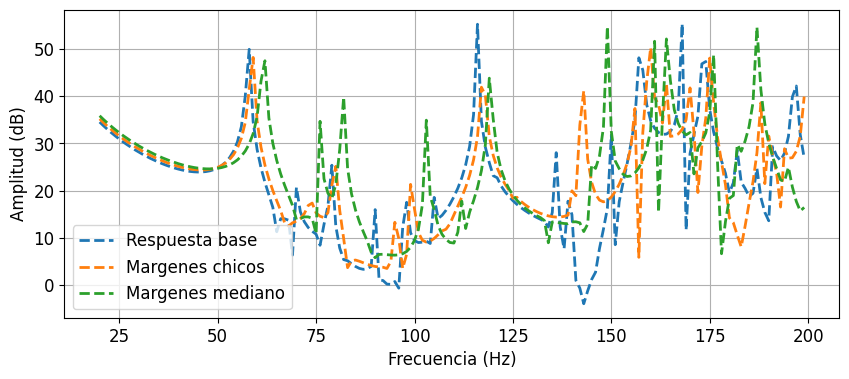

In [37]:
from plots.graph_mag_response import mag_response_comparison

freqs_res1 = np.arange(20, 200, 1)
mags = [(freqs_res1, mag0, "Respuesta base"), (f_tot, best_mag_small_margin, "Margenes chicos"), (f_tot, best_room_mag, "Margenes mediano")]
mag_response_comparison(mags)

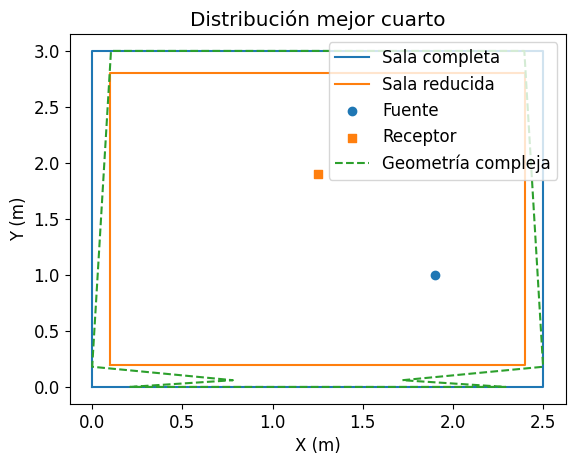

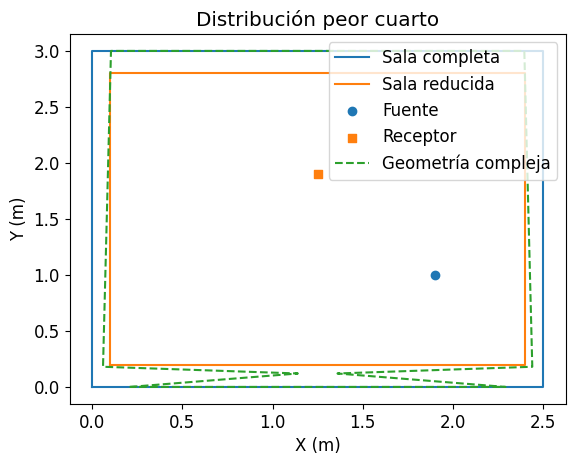

La mejor sala es:  [[0.20833333 0.        ]
 [0.78       0.06      ]
 [0.         0.18      ]
 [0.10416667 3.        ]
 [2.39583333 3.        ]
 [2.5        0.18      ]
 [1.72       0.06      ]
 [2.29166667 0.        ]]
............................
La peor sala es:  [[0.20833333 0.        ]
 [1.14       0.12      ]
 [0.06       0.18      ]
 [0.10416667 3.        ]
 [2.39583333 3.        ]
 [2.44       0.18      ]
 [1.36       0.12      ]
 [2.29166667 0.        ]]


In [30]:
plot_room_outline(Lx, Ly, Dx, Dy, source_position, receptor_position, rooms[idx_best_room], "Distribución mejor cuarto")
plot_room_outline(Lx, Ly, Dx, Dy, source_position, receptor_position, rooms[idx_worst_room], "Distribución peor cuarto")

print("La mejor sala es: ", rooms[idx_best_room])
print("............................")
print("La peor sala es: ", rooms[idx_worst_room])

Respuesta con margenes medianos

In [36]:
print(f"El valor de mértio mínimo es: {merit_general[idx_best_room]} | Con SV: {merit_sv_values[idx_best_room]} | Con MD: {merit_md_values[idx_best_room]}" )
print("............................")
print(f"El peor valor de mérito es: {merit_general[idx_worst_room]} | Con SV: {merit_sv_values[idx_worst_room]} | Con MD: {merit_md_values[idx_worst_room]}" )
print("............................")
print("El valor de mértio promedio es: ", np.mean(merit_general))
print("............................")
print("El tiempo de ejecución en minutos fue de: ", (time.time() - start_time)/60)

El valor de mértio mínimo es: 14.188930646739838 | Con SV: 3.1312769963695795 | Con MD: 11.05765365037026
............................
El peor valor de mérito es: 18.566756430201856 | Con SV: 4.016080458110956 | Con MD: 14.550675972090898
............................
El valor de mértio promedio es:  16.124178125376137
............................
El tiempo de ejecución en minutos fue de:  62.308164687951404


In [ ]:
from complex_outline_optim import calculate_initial

merit_0, mag0 = calculate_initial(Lx/100, Ly/100, Lz/100, source_position, receptor_position)
freq_base = np.arange(20, 200, 1)
merit_0

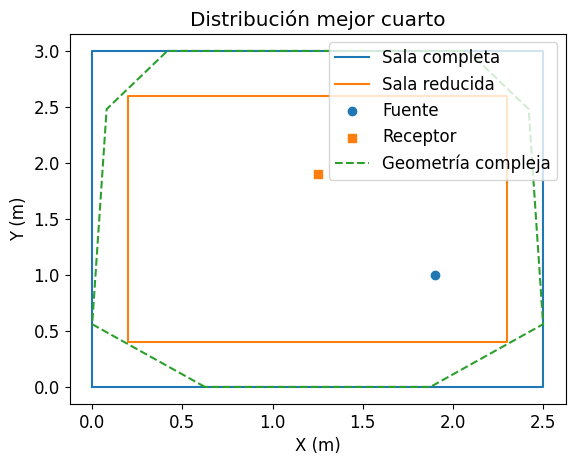

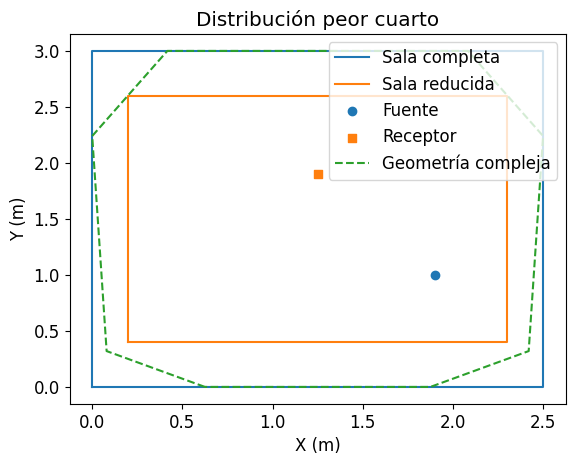

La mejor sala es:  [[0.625      0.        ]
 [0.         0.56      ]
 [0.08       2.48      ]
 [0.41666667 3.        ]
 [2.08333333 3.        ]
 [2.42       2.48      ]
 [2.5        0.56      ]
 [1.875      0.        ]]
............................
La peor sala es:  [[0.625      0.        ]
 [0.08       0.32      ]
 [0.         2.24      ]
 [0.41666667 3.        ]
 [2.08333333 3.        ]
 [2.5        2.24      ]
 [2.42       0.32      ]
 [1.875      0.        ]]


In [38]:
plot_room_outline(Lx, Ly, Dx, Dy, source_position, receptor_position, rooms[idx_best_room], "Distribución mejor cuarto")
plot_room_outline(Lx, Ly, Dx, Dy, source_position, receptor_position, rooms[idx_worst_room], "Distribución peor cuarto")

print("La mejor sala es: ", rooms[idx_best_room])
print("............................")
print("La peor sala es: ", rooms[idx_worst_room])

Respuesta con margenes grandes (es la versión normal)